# Imoprt important libraries

In [1]:
import pandas as pd
import numpy as np
import string, os,re,pickle
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from keras.preprocessing.text import Tokenizer
import keras.utils as ku 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import io
import cufflinks as cf
cf.go_offline()

%matplotlib inline

In [2]:
df1 = pd.read_csv('../input/ted-talks/ted_main.csv')
transcripts = pd.read_csv('../input/ted-talks/transcripts.csv')

In [3]:
df1.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [4]:
transcripts.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  url                 2550 non-null   object
 16  views               2550

In [6]:
df1.isnull().sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

### missing null values
as there are only 6 null values in the occupation column we can fill it with the mode value of the column to keep the 2550 numbers even

In [7]:
df1['speaker_occupation'] = df1.speaker_occupation.fillna(df1.speaker_occupation.mode()[0])

# **EXPLORATORY DATA ANALYSIS**

In [8]:
#converting to datetime object
df1['film_date'] = pd.to_datetime(df1['film_date'], unit='s')
df1['published_date'] = pd.to_datetime(df1['published_date'], unit='s')

#creating a year column
df1['year'] = df1['film_date'].apply(lambda x: x.year)

#converting duration unit to minute
df1['duration'] = df1['duration'].apply(lambda x: round(x/60, 2))

### ▶ Number of TED talks throughout the years

<AxesSubplot:>

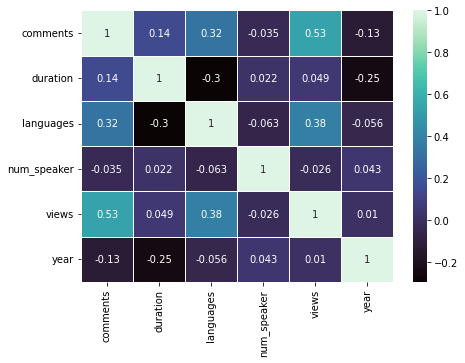

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))    
sns.heatmap(df1.corr(), annot = True, linewidths =.5, ax = ax, cmap = 'mako')

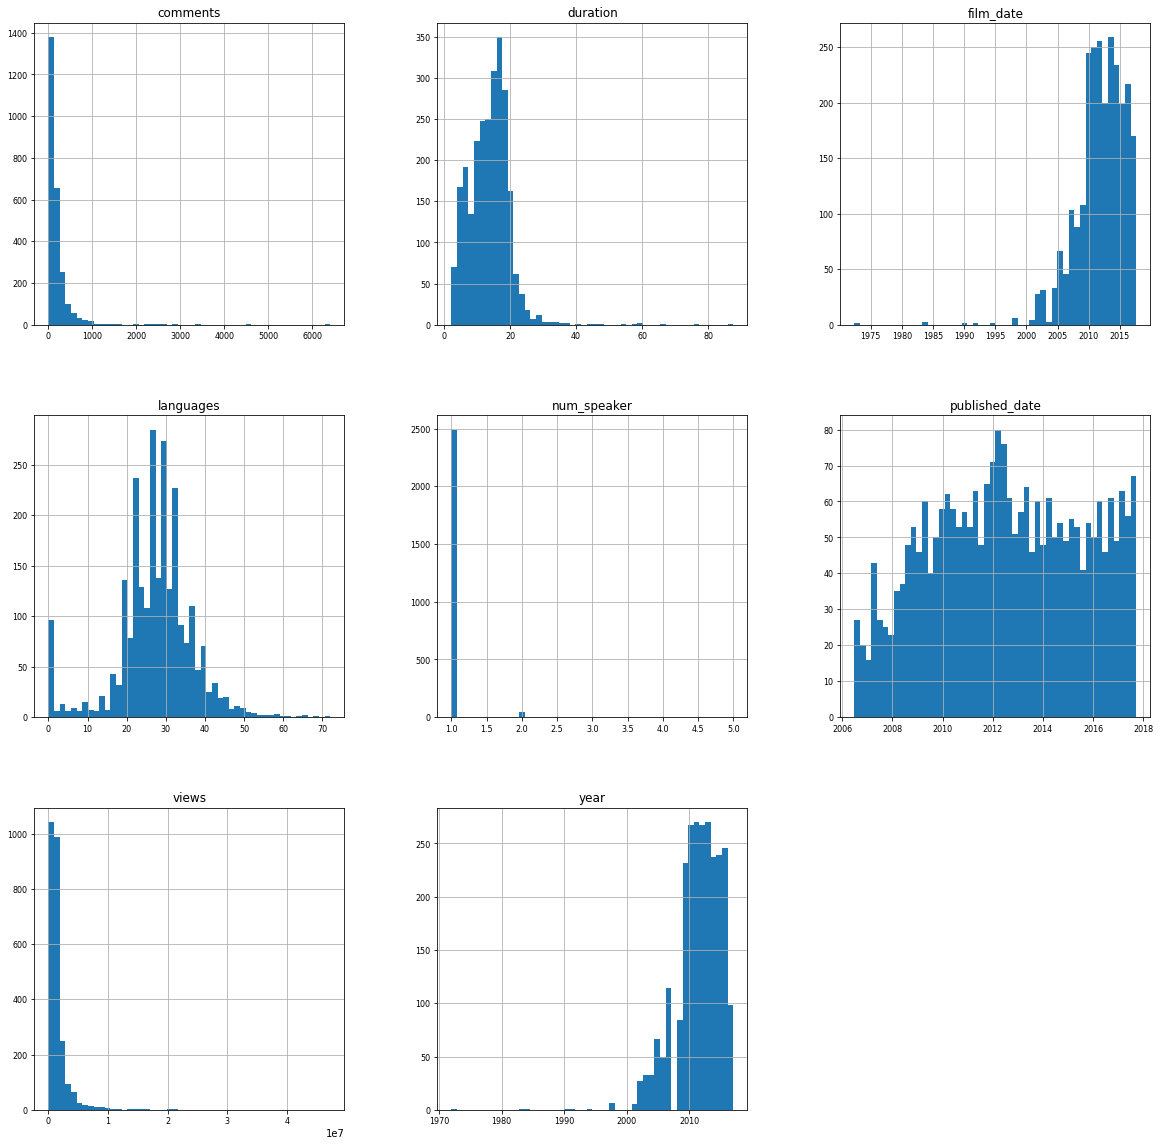

In [10]:
df1.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8); 

### ▶ Checking the distribution of view, comments, and duration

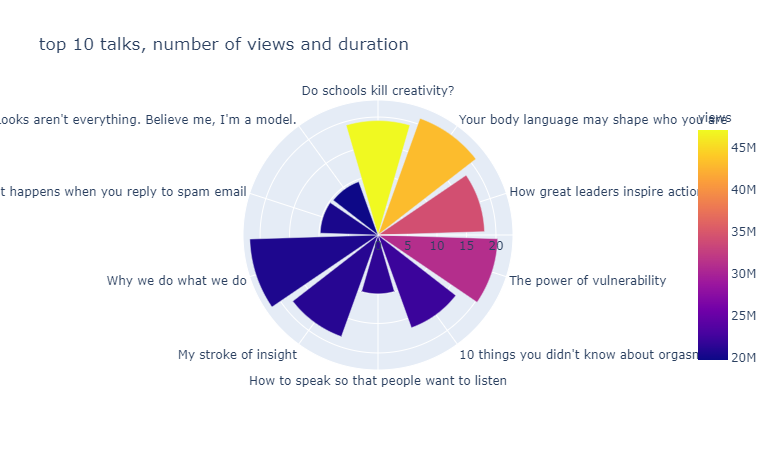

In [11]:
views = df1.sort_values(by = 'views', ascending = False).head(10).reset_index()


fig = px.bar_polar(views, 
                   r="duration", 
                   theta="title", 
                   color="views",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   title="top 10 talks, number of views and duration"
                  )
fig.show()

### ▶ top 10 TED events held

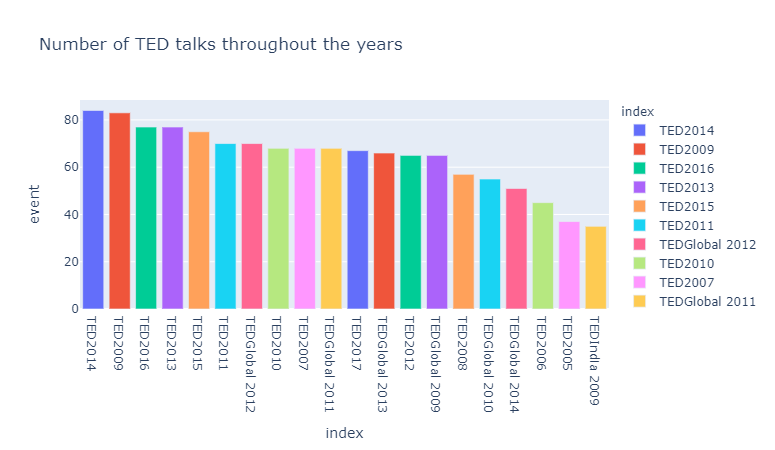

In [12]:
events = pd.DataFrame(df1['event'].value_counts().head(20)).reset_index()


fig = px.bar(events, 
             x ='index', 
             y='event',
             color = 'index',
             color_continuous_scale = px.colors.sequential.Oryel, 
             title=' Number of TED talks throughout the years',
             labels=dict(x= "year", y="number of talks", color = 'year'))
fig.show()

### ▶ relation between views and comments of talks

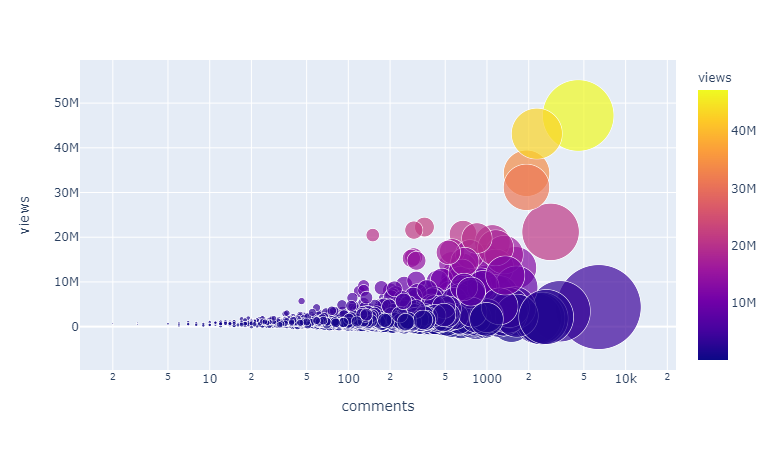

In [13]:
fig = px.scatter(df1, 
                 x = "comments", 
                 y = "views", 
                 size = "comments", 
                 color = "views",
                 hover_name="title", 
                 log_x=True, 
                 size_max=60)
fig.show()

### ▶ what are the most repeated occupations of speakers

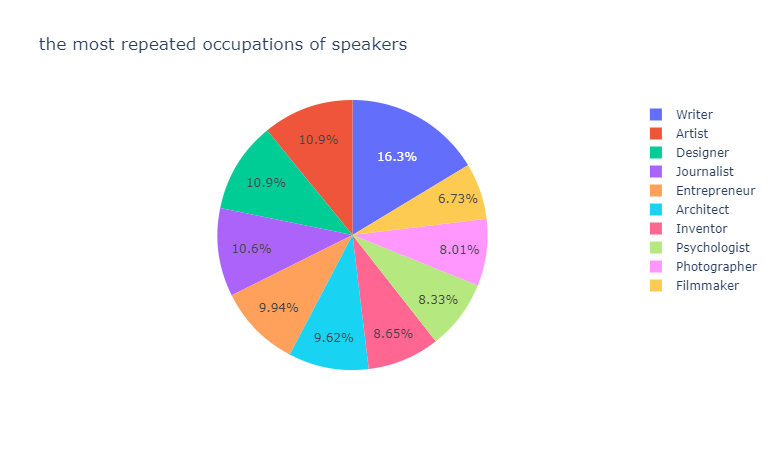

we can see that writers represent the greatest portion of speaker's occupations


In [14]:
speakers = pd.DataFrame(df1['speaker_occupation'].value_counts().head(10)).reset_index()

fig = px.pie(speakers, 
             values='speaker_occupation', 
             names='index', 
             title='the most repeated occupations of speakers')
fig.show()
print("we can see that writers represent the greatest portion of speaker's occupations")

### ▶ Longest 10 talks

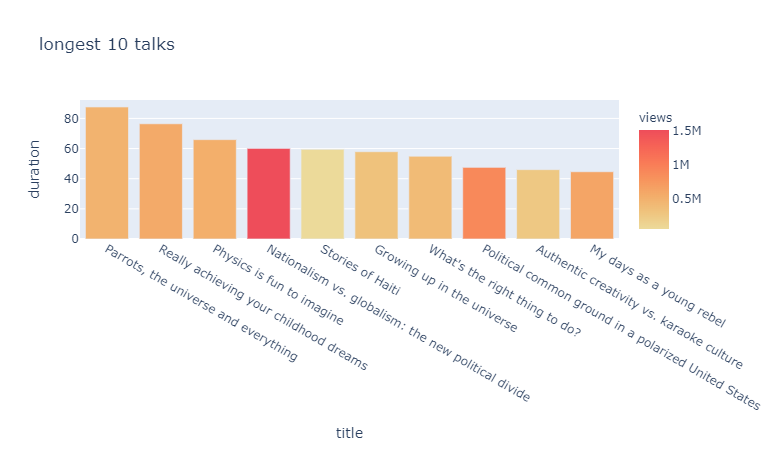

In [15]:
duration = df1.sort_values(by = 'duration', ascending = False).head(10)

fig = px.bar(duration, 
             x ='title', 
             y='duration',
             color = 'views',
             color_continuous_scale = px.colors.sequential.Oryel, 
             title='longest 10 talks')
fig.show()

### ▶ Number of TED talks throughout the years

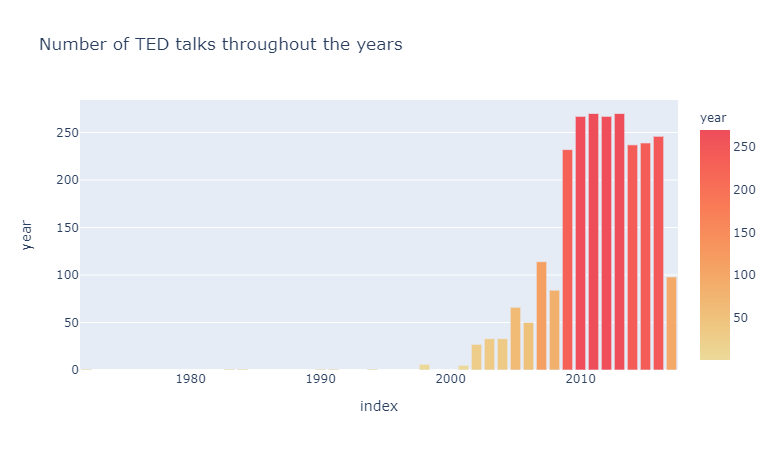

In [16]:
years = pd.DataFrame(df1['year'].value_counts()).reset_index()

fig = px.bar(years, 
             x ='index', 
             y='year',
             color = 'year',
             color_continuous_scale = px.colors.sequential.Oryel, 
             title=' Number of TED talks throughout the years',
             labels=dict(x= "year", y="number of talks", color = 'number'))
fig.show()

### ▶ Number of words in each talk

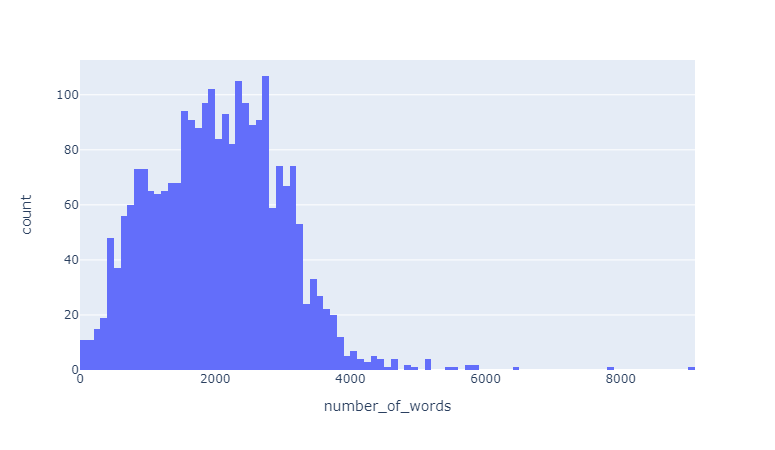

In [17]:
transcripts['number_of_words']= transcripts['transcript'].str.split().str.len()

fig = px.histogram(transcripts, x="number_of_words", hover_data=transcripts.columns)
fig.show()

## Text Generation Model

In [18]:
transcripts.head()

,transcript,url,number_of_words
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,3066
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,2089
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,3253
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,3015
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,3121


In [19]:
transcripts.shape

(2467, 3)

In [20]:
c=0
for i in transcripts["transcript"]:
    c=c+len(i)
print ("Total Words in Data:",c)

Total Words in Data: 28218860


In [21]:
transcripts["transcript"][0]

'Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you

## convert data to text

In [22]:
text=""
for i in transcripts["transcript"]:
    text+=i

In [23]:
text[-100:]

'might be that this is not just a game. It might be a way to decide our own fate.Thank you.(Applause)'

In [24]:
len(text)

28218860

As the data is huge..
We selected slice of text to train the model

In [25]:
train_text=text[:500000]

In [26]:
len(train_text)

500000

## text Cleaning

In [27]:
cleaned_text=[]
txt=re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", train_text)
txt=txt.strip().replace("\'","'")
for i in txt:
    if i not in string.punctuation.replace("'",""):
        cleaned_text.append(i)
    else:
        cleaned_text.append(" ")
cleaned_text="".join(cleaned_text).lower()

In [28]:
cleaned_text[:100]

"good morning  how are you   it's been great  hasn't it  i've been blown away by the whole thing  in "

## tokenizer

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([cleaned_text])

# saving the tokenizer for predict function
#pickle.dump(tokenizer, open('/content/drive/MyDrive/ted talks/token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([cleaned_text])[0]
sequence_data[:15]

[130, 715, 67, 24, 9, 23, 99, 176, 2915, 11, 131, 99, 1334, 254, 65]

In [30]:
tokenizer.index_word

{1: 'the',
 2: 'and',
 3: 'to',
 4: 'of',
 5: 'a',
 6: 'i',
 7: 'that',
 8: 'in',
 9: 'you',
 10: 'is',
 11: 'it',
 12: 'this',
 13: 'we',
 14: '—',
 15: 'so',
 16: 'was',
 17: 'they',
 18: 'have',
 19: 'what',
 20: 'on',
 21: 'but',
 22: 'for',
 23: "it's",
 24: 'are',
 25: 'about',
 26: 'with',
 27: 'all',
 28: 'be',
 29: 'not',
 30: 'people',
 31: 'do',
 32: 'like',
 33: 'can',
 34: 'one',
 35: 'at',
 36: 'my',
 37: 'because',
 38: 'as',
 39: 'there',
 40: 'if',
 41: 'just',
 42: 'know',
 43: 'an',
 44: 'me',
 45: 'out',
 46: 'from',
 47: 'think',
 48: 'or',
 49: "i'm",
 50: 'world',
 51: 'he',
 52: 'them',
 53: 'really',
 54: "that's",
 55: 'now',
 56: 'going',
 57: 'said',
 58: "don't",
 59: 'when',
 60: 'had',
 61: 'very',
 62: 'your',
 63: 'get',
 64: 'these',
 65: 'by',
 66: 'would',
 67: 'how',
 68: 'who',
 69: 'up',
 70: 'which',
 71: 'our',
 72: 'were',
 73: 'here',
 74: 'years',
 75: 'their',
 76: 'then',
 77: 'more',
 78: 'things',
 79: 'want',
 80: 'some',
 81: 'say',
 82

In [31]:
len(sequence_data)

90618

In [32]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7989


# Make sequences

In [33]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  90615


array([[ 130,  715,   67,   24],
       [ 715,   67,   24,    9],
       [  67,   24,    9,   23],
       [  24,    9,   23,   99],
       [   9,   23,   99,  176],
       [  23,   99,  176, 2915],
       [  99,  176, 2915,   11],
       [ 176, 2915,   11,  131],
       [2915,   11,  131,   99],
       [  11,  131,   99, 1334]])

# split sequences 

In [34]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [35]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[ 130  715   67]
 [ 715   67   24]
 [  67   24    9]
 [  24    9   23]
 [   9   23   99]
 [  23   99  176]
 [  99  176 2915]
 [ 176 2915   11]
 [2915   11  131]
 [  11  131   99]]
Response:  [  24    9   23   99  176 2915   11  131   99 1334]


In [36]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Train Test Split

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1

this model takes 3 words as inputs

In [39]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 10, input_length=3))
model1.add(LSTM(1000, return_sequences=True))
model1.add(LSTM(1000))
model1.add(Dense(1000, activation="relu"))
model1.add(Dense(vocab_size, activation="softmax"))

In [40]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 10)             79890     
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 1000)           4044000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 7989)              7996989   
Total params: 21,125,879
Trainable params: 21,125,879
Non-trainable params: 0
_________________________________________________________________


In [44]:
#checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])
model1.fit(X_train, y_train, epochs=70, batch_size=32)

2022-01-10 23:17:17.401642: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2316554352 exceeds 10% of free system memory.
2022-01-10 23:17:19.681537: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2316554352 exceeds 10% of free system memory.
2022-01-10 23:17:21.349790: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-01-10 23:17:24.419616: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2266/2266 [==============================] - 31s 12ms/step - loss: 6.4913 - accuracy: 0.0579
Epoch 2/70
2266/2266 [==============================] - 26s 12ms/step - loss: 5.9640 - accuracy: 0.0933
Epoch 3/70
2266/2266 [==============================] - 26s 12ms/step - loss: 5.6617 - accuracy: 0.1071
Epoch 4/70
2266/2266 [==============================] - 26s 12ms/step - loss: 5.4316 - accuracy: 0.1182
Epoch 5/70
2266/2266 [==============================] - 26s 11ms/step - loss: 5.2383 - accuracy: 0.1289
Epoch 6/70
2266/2266 [==============================] - 26s 12ms/step - loss: 5.0584 - accuracy: 0.1374
Epoch 7/70
2266/2266 [==============================] - 26s 12ms/step - loss: 4.8893 - accuracy: 0.1489
Epoch 8/70
2266/2266 [==============================] - 27s 12ms/step - loss: 4.7165 - accuracy: 0.1555
Epoch 9/70
2266/2266 [==============================] - 27s 12ms/step - loss: 4.5441 - accuracy: 0.1642
Epoch 10/70
2266/2266 [==============================] - 26s 12ms/step - lo

<AxesSubplot:>

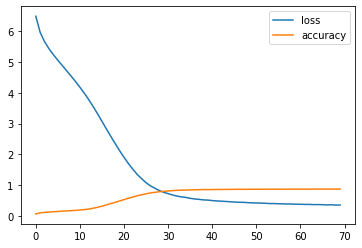

In [47]:
losses1=pd.DataFrame(model1.history.history)
losses1.plot()

## Load Model 1

In [45]:
# Load the model and tokenizer
#model = load_model('next_words.h5')
#tokenizer = pickle.load(open('token.pkl', 'rb'))

## Predict Words

In [51]:
def Predict_Words(model, tokenizer, text,n_word):
    result=text
    for _ in range(n_word):
        sequence = tokenizer.texts_to_sequences([text])
        sequence = np.array(sequence)
        preds = np.argmax(model.predict(sequence))
        predicted_word = ""

        for key, value in tokenizer.word_index.items():
            if value == preds:
                predicted_word = key
                break
        result+=" "+predicted_word
        text=str(text)
        text = text.split(" ")
        text = text[-3:]
        text+=" "+predicted_word

    return result

In [52]:
#good
print(Predict_Words(model1, tokenizer, "What surprised you",1))
print(Predict_Words(model1, tokenizer, "have been three",1))
print(Predict_Words(model1, tokenizer, "I get a chance",2))
print(Predict_Words(model1, tokenizer, "last case of",2))
print(Predict_Words(model1, tokenizer, "I'm really grateful",4))
print(Predict_Words(model1, tokenizer, "human creativity in",2))

What surprised you about
have been three themes
I get a chance that's for
last case of killer our
I'm really grateful that put and maybe
human creativity in all form


In [53]:
#not so good
print(Predict_Words(model1, tokenizer, "good morning my",2))
print( Predict_Words(model1, tokenizer, "I would have never",3))
print(Predict_Words(model1, tokenizer, "I have an interest",2))
print(Predict_Words(model1, tokenizer, "If you work",4))

good morning my call neutral
I would have never won many human
I have an interest in decisions
If you work 10 when years where


In [85]:
print( Predict_Words(model1, tokenizer, "I would have never",22))

I would have never won many human waste seven pages who and maybe google and maybe google and maybe google and maybe google and maybe google


# Model 2

another model take 3 words as input

In [54]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 10, input_length=3))
model2.add(LSTM(1000, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(1000))
model2.add(Dropout(0.2))
model2.add(Dense(1000, activation="relu"))
model2.add(Dense(vocab_size, activation="softmax"))

In [55]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3, 10)             79890     
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 1000)           4044000   
_________________________________________________________________
dropout (Dropout)            (None, 3, 1000)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_5 (Dense)              (None, 7989)             

In [56]:
#checkpoint = ModelCheckpoint("next_words_3.h5", monitor='loss', verbose=1, save_best_only=True)
model2.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])
model2.fit(X_train, y_train, epochs=70, batch_size=64,validation_data=[X_test,y_test])

2022-01-10 23:53:09.913541: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2316554352 exceeds 10% of free system memory.
2022-01-10 23:53:12.351431: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2316554352 exceeds 10% of free system memory.


Epoch 1/70
1132/1133 [============================>.] - ETA: 0s - loss: 6.5743 - accuracy: 0.0525

2022-01-10 23:53:31.900627: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 579138588 exceeds 10% of free system memory.


1133/1133 [==============================] - 20s 15ms/step - loss: 6.5741 - accuracy: 0.0524 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/70
1133/1133 [==============================] - 16s 14ms/step - loss: 6.0662 - accuracy: 0.0814 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/70
1133/1133 [==============================] - 15s 14ms/step - loss: 5.7417 - accuracy: 0.1019 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/70
1133/1133 [==============================] - 16s 14ms/step - loss: 5.4905 - accuracy: 0.1137 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/70
1133/1133 [==============================] - 15s 14ms/step - loss: 5.2843 - accuracy: 0.1249 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/70
1133/1133 [==============================] - 16s 14ms/step - loss: 5.0825 - accuracy: 0.1349 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/70
1133/1133 [==============================] - 15s 14ms/step - loss: 4.8740 - 

In [57]:
losses2=pd.DataFrame(model2.history.history)
losses2.head()

,loss,accuracy,val_loss,val_accuracy
0,6.574082,0.052447,0.0,0.0
1,6.066215,0.081443,0.0,0.0
2,5.741695,0.101873,0.0,0.0
3,5.490496,0.113737,0.0,0.0
4,5.284340,0.124883,0.0,0.0


<AxesSubplot:>

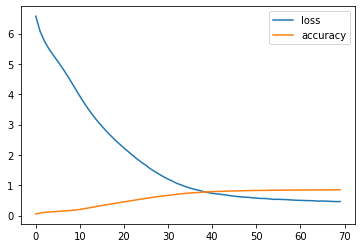

In [58]:
losses2[["loss","accuracy"]].plot()

<AxesSubplot:>

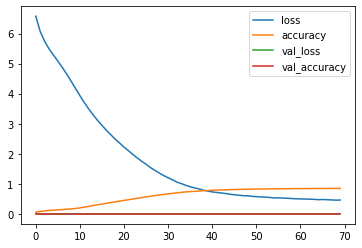

In [59]:
losses2.plot()

## load model

In [60]:
# Load the model and tokenizer
#loaded_model = load_model('next_words_3.h5')
#tokenizer = pickle.load(open('token.pkl', 'rb'))

## prediction

In [61]:
#good
print(Predict_Words(model2, tokenizer, "What surprised you",2))
print(Predict_Words(model2, tokenizer, "have been three",1))
print(Predict_Words(model2, tokenizer, "last case of",3))
print(Predict_Words(model2, tokenizer, "I'm really grateful",4))
print(Predict_Words(model2, tokenizer, "human creativity in",2))
print(Predict_Words(model2, tokenizer, "good morning my",3))
print( Predict_Words(model2, tokenizer, "I would have never",2))

What surprised you about be
have been three themes
last case of killer would would
I'm really grateful that the has —
human creativity in all i
good morning my son our and
I would have never lost got


In [63]:
#not so good
print(Predict_Words(model2, tokenizer, "I get a chance",5))
print(Predict_Words(model2, tokenizer, "I have an interest",2))
print(Predict_Words(model2, tokenizer, "If you work",5))

I get a chance to makes was place citizens
I have an interest in to
If you work 10 to had culture to


In [84]:
print( Predict_Words(model2, tokenizer, "I would have never",22))

I would have never lost got and because he's that i don't unhealthy great climbed is discovered a couple we the has — i was the


# Model 3

take 2 words as input

## preprocessing for Model

In [64]:
sequences = []

for i in range(2, len(sequence_data)):
    words = sequence_data[i-2:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  90616


array([[ 130,  715,   67],
       [ 715,   67,   24],
       [  67,   24,    9],
       [  24,    9,   23],
       [   9,   23,   99],
       [  23,   99,  176],
       [  99,  176, 2915],
       [ 176, 2915,   11],
       [2915,   11,  131],
       [  11,  131,   99]])

In [65]:
X = []
y = []

for i in sequences:
    X.append(i[0:2])
    y.append(i[2])
    
X = np.array(X)
y = np.array(y)

In [66]:
print("Data: ", X[:10])
print("Response: ", y[:10])


Data:  [[ 130  715]
 [ 715   67]
 [  67   24]
 [  24    9]
 [   9   23]
 [  23   99]
 [  99  176]
 [ 176 2915]
 [2915   11]
 [  11  131]]
Response:  [  67   24    9   23   99  176 2915   11  131   99]


In [67]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
len(X_train)

72492

## Model 

In [70]:
model3 = Sequential()
model3.add(Embedding(vocab_size, 10, input_length=2))
model3.add(LSTM(1000, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(1000, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(800))
model3.add(Dropout(0.2))
model3.add(Dense(1000, activation="relu"))
model3.add(Dense(vocab_size, activation="softmax"))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2, 10)             79890     
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 1000)           4044000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1000)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 2, 1000)           8004000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 1000)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 800)               5763200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 800)              

In [71]:
#checkpoint = ModelCheckpoint("next_words_4.h5", monitor='loss', verbose=1, save_best_only=True)
model3.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=70, batch_size=64,validation_data=(X_test,y_test))


Epoch 1/70
1133/1133 [==============================] - 25s 18ms/step - loss: 6.5598 - accuracy: 0.0534 - val_loss: 6.3809 - val_accuracy: 0.0637
Epoch 2/70
1133/1133 [==============================] - 19s 17ms/step - loss: 6.0807 - accuracy: 0.0782 - val_loss: 6.2097 - val_accuracy: 0.0846
Epoch 3/70
1133/1133 [==============================] - 19s 16ms/step - loss: 5.7572 - accuracy: 0.0991 - val_loss: 6.1994 - val_accuracy: 0.0976
Epoch 4/70
1133/1133 [==============================] - 19s 17ms/step - loss: 5.5105 - accuracy: 0.1121 - val_loss: 6.2759 - val_accuracy: 0.1046
Epoch 5/70
1133/1133 [==============================] - 19s 16ms/step - loss: 5.3070 - accuracy: 0.1223 - val_loss: 6.2932 - val_accuracy: 0.1102
Epoch 6/70
1133/1133 [==============================] - 19s 17ms/step - loss: 5.1164 - accuracy: 0.1316 - val_loss: 6.4428 - val_accuracy: 0.1159
Epoch 7/70
1133/1133 [==============================] - 19s 17ms/step - loss: 4.9293 - accuracy: 0.1389 - val_loss: 6.5637 -

<AxesSubplot:>

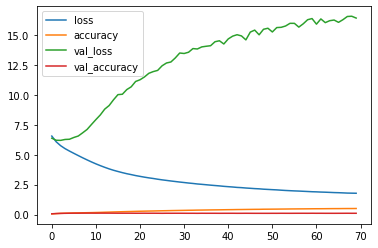

In [72]:
losses3=pd.DataFrame(model3.history.history)
losses3.plot()

<AxesSubplot:>

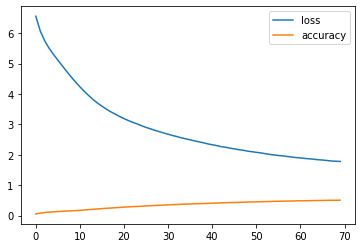

In [73]:
losses3[["loss","accuracy"]].plot()

## load Model

In [74]:
# Load the model and tokenizer
#loaded_model = load_model('next_words_4.h5')
#tokenizer = pickle.load(open('token.pkl', 'rb'))

## Model Predict

In [75]:
#good
print(Predict_Words(model3, tokenizer, "What surprised",2))
print(Predict_Words(model3, tokenizer, "have been three",1))
print(Predict_Words(model3, tokenizer, "last case of",2))
print(Predict_Words(model3, tokenizer, "I'm really grateful",4))
print(Predict_Words(model3, tokenizer, "human creativity in",2))
print(Predict_Words(model3, tokenizer, "good morning my",3))
print( Predict_Words(model3, tokenizer, "I would have never",2))

What surprised you need
have been three and
last case of a it
I'm really grateful to talk today the
human creativity in my forward
good morning my name this the
I would have never do their


In [76]:
print( Predict_Words(model3, tokenizer, "I would have never",22))

I would have never do their member in to use theory yesterday the been told and and and and and and and and and and and


# Model 4

another model take 2 words as input

## Model

In [77]:
model4 = Sequential()
model4.add(Embedding(vocab_size, 10, input_length=2))
model4.add(LSTM(1000, return_sequences=True))
model4.add(Dropout(0.1))
model4.add(LSTM(1000, return_sequences=True))
model4.add(Dropout(0.1))
model4.add(LSTM(800))
model4.add(Dropout(0.1))
model4.add(Dense(800, activation="relu"))
model4.add(Dense(600, activation="relu"))
model4.add(Dense(vocab_size, activation="softmax"))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2, 10)             79890     
_________________________________________________________________
lstm_9 (LSTM)                (None, 2, 1000)           4044000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 1000)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 2, 1000)           8004000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 1000)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 800)               5763200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 800)              

In [78]:
#checkpoint = ModelCheckpoint("next_words_5.h5", monitor='loss', verbose=1, save_best_only=True)
model4.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model4.fit(X_train, y_train, epochs=70, batch_size=64,validation_data=(X_test,y_test))

Epoch 1/70
1133/1133 [==============================] - 24s 18ms/step - loss: 6.5781 - accuracy: 0.0508 - val_loss: 6.3698 - val_accuracy: 0.0623
Epoch 2/70
1133/1133 [==============================] - 18s 16ms/step - loss: 6.1034 - accuracy: 0.0769 - val_loss: 6.2296 - val_accuracy: 0.0851
Epoch 3/70
1133/1133 [==============================] - 18s 16ms/step - loss: 5.8041 - accuracy: 0.1002 - val_loss: 6.1696 - val_accuracy: 0.0980
Epoch 4/70
1133/1133 [==============================] - 18s 16ms/step - loss: 5.5899 - accuracy: 0.1119 - val_loss: 6.1900 - val_accuracy: 0.1028
Epoch 5/70
1133/1133 [==============================] - 18s 16ms/step - loss: 5.4084 - accuracy: 0.1210 - val_loss: 6.2344 - val_accuracy: 0.1104
Epoch 6/70
1133/1133 [==============================] - 18s 16ms/step - loss: 5.2485 - accuracy: 0.1307 - val_loss: 6.3110 - val_accuracy: 0.1144
Epoch 7/70
1133/1133 [==============================] - 18s 16ms/step - loss: 5.0931 - accuracy: 0.1371 - val_loss: 6.4349 -

<AxesSubplot:>

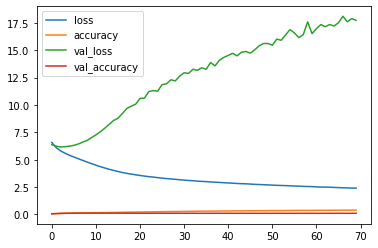

In [79]:
losses4=pd.DataFrame(model4.history.history)
losses4.plot()

<AxesSubplot:>

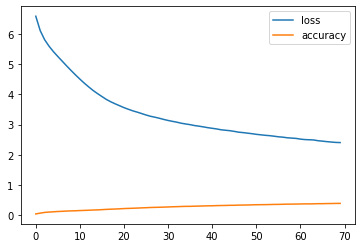

In [82]:
losses4[["loss","accuracy"]].plot()

## load model

In [80]:
# Load the model and tokenizer
#loaded_model = load_model('next_words_5.h5')
#tokenizer = pickle.load(open('token.pkl', 'rb'))

## prediction

In [81]:
print(Predict_Words(model4, tokenizer, "What surprised",5))
print(Predict_Words(model4, tokenizer, "have been three",1))
print(Predict_Words(model4, tokenizer, "last case of",2))
print(Predict_Words(model4, tokenizer, "I'm really grateful",4))
print(Predict_Words(model4, tokenizer, "human creativity in",2))
print(Predict_Words(model4, tokenizer, "good morning my",3))
print( Predict_Words(model4, tokenizer, "I would have never",2))

What surprised the social parade use epiphany
have been three projects
last case of development technology
I'm really grateful of this made and
human creativity in have is
good morning my use cycle cultural
I would have never left minds


In [83]:
print( Predict_Words(model4, tokenizer, "I would have never",22))

I would have never left minds here right worst ideas selling communion question allah divergent international technology urban real little theater sewage with dollars you public
